<a href="https://colab.research.google.com/github/NicoleMeinie/Regression/blob/master/Zindi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

The dataset provided by Sendy includes order details and rider metrics based on orders made on the Sendy platform. The challenge is to predict the estimated time of arrival for orders- from pick-up to drop-off.

Sendy provides an API as well as a web and mobile application platform to link customers who have delivery needs with vetted transporters. The customers select their vehicle of choice, get their price quote upfront and pay using various payment options. The system optimises the route, looks for the closest available riders and dispatches the orders in the most efficient way.

The training dataset provided here is a subset of over 20,000 orders and only includes direct orders (i.e. Sendy “express” orders) with bikes in Nairobi. All data in this subset have been fully anonymized while preserving the distribution.

###The approach followed in this challenge is outlined below:

*   Visualize and explore the dataset
*   Select which features to use
*   Train prediction models
*   Evaluate the trained models
*   Select the best performing model
*   submit results







##Import libraries and upload data


In [0]:
# Importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# should these be here or in the body of the code? - PEP8
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# avoid pd warnings 
import warnings
warnings.filterwarnings("ignore")

# upload data
Test = pd.read_csv('Test.csv')
Train = pd.read_csv('Train.csv')
Riders = pd.read_csv('Riders.csv')
Sub = pd.read_csv('SampleSubmission.csv')

# merge drivers's informations with the train and test datasets
Train = Train.merge(Riders, on='Rider Id', how='left')
Test = Test.merge(Riders, on='Rider Id', how='left')


#Exploratory Data Analysis

## Summary Statistics 

In this section the data types and the summary statistics of the given variables will be explored.
 

In [21]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [22]:
Train.describe().T


,count,mean,std,min,25%,50%,75%,max
Platform Type,21201.0,2.752182,0.625178,1.000000,3.000000,3.000000,3.000000,4.000000
Placement - Day of Month,21201.0,15.653696,8.798916,1.000000,8.000000,15.000000,23.000000,31.000000
Placement - Weekday (Mo = 1),21201.0,3.240083,1.567295,1.000000,2.000000,3.000000,5.000000,7.000000
Confirmation - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Confirmation - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival at Pickup - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Arrival at Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Pickup - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival at Destination - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000


**Observations:**


*   There are oders with a delivery time of 1 second. These could be data points that weren't recorded properly. In practice these rows should be excluded when training the model. (any rows where the delivery time is less than 2 minutes would be flagged as suspicious and drpped from the dataset. We will keep them for the sake of the compition, though)


*   The 'Temperature' and 'Percipitation' columns contain Null values.


*   There are a few 'object' type columns that will either need to be converted or dropped.


* Based on the means and standard deviations of different columns, the dataset will need to be standardized.


##Distribution of the feature and response variables

A histogram of delivery times as well as the outlier threshold will be plotted to viuslize the distribution of the delivery times *(response/target variable)*.

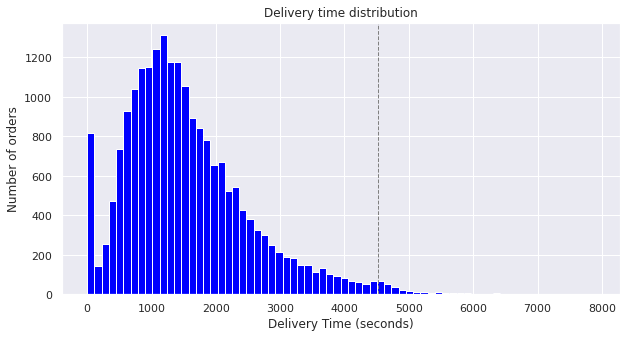

In [23]:
# Calculating the outlier threshold 
mu = Train.iloc[:,28].mean()
sd = Train.iloc[:,28].std()
li = mu + 3*sd

# creating the histogram - distribution of delivery times in seconds
sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.hist(Train.iloc[:,28], bins = 70, color = 'blue')
_ = plt.title('Delivery time distribution')
_ = plt.xlabel('Delivery Time (seconds)')
_ = plt.ylabel('Number of orders')
_ = plt.axvline(li, color = 'gray', linestyle = 'dashed', linewidth = 1)
plt.show()

**Observations:**

*   From the plot above it’s clear that the delivery times are possitively skewed, with the majority of orders being delivered in about 16 minutes 

*   There are orders with a delivery time of 1 second. These could be data points that weren't recorded properly. In practice these rows should be excluded when training the model. (any rows where the delivery time is less than 2 minutes would be flagged as suspicious and drpped from the dataset. We will keep them for the sake of the compition, though) : Its actually a big chunk - should we just drop it?

* The grey dotted line above indicates the threshold for existance of outliers (measured by the presence of values 3 standard deviation away from the mean.) A small portion of the delivery times recorded with times > 4500 seconds can be considered outliers





###Distribution plots for all the features in the data set.



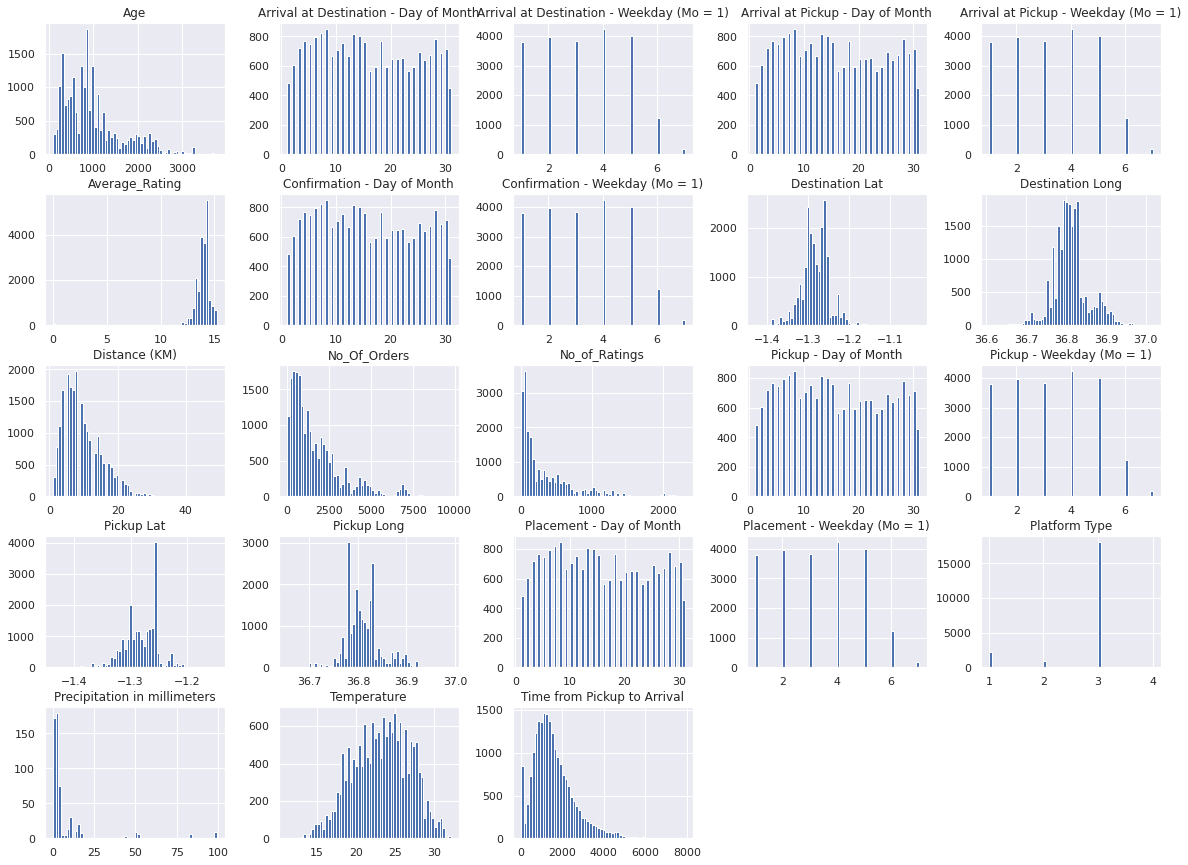

In [24]:
# creating a histogram for all the variables in the dataset to visulize the distribution of each feature
sns.set()
Train.hist(bins = 60, figsize = (20,15))
plt.show()

**Observations:**


*   Majority of the orders are placed using platform 3 and only a tiny portion using platform 4
*   Weekends are not as busy compared to weekdays 
* Most orders are delivered within a 10km radius
* Orders are spread out almost evenly across the day of the month - no obvious popular day
* Most Temperatures fall between 20 and 27 degrees celcius
* The average driver rating is between 13 and 15 with vary little varience 
* A large portion of riders have no or very few ratings



## Exploring the relationship between delivery time and a few features

### Distance
The relationship between delivery time and distance travelled is plotted first


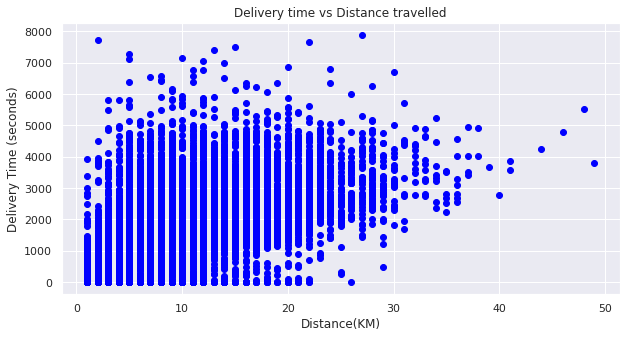

In [25]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.scatter(Train.iloc[:,20],Train.iloc[:,28], color = 'blue')
_ = plt.title('Delivery time vs Distance travelled')
_ = plt.xlabel('Distance(KM)')
_ = plt.ylabel('Delivery Time (seconds)')
plt.show()

**Observations:**

*   The relationship between distance and delivery time is intuitive and seems linear even for outliers

### Day of the week

Next the relationship between the day of the week that orders are placed and the delivery times is visualized using a violin plot

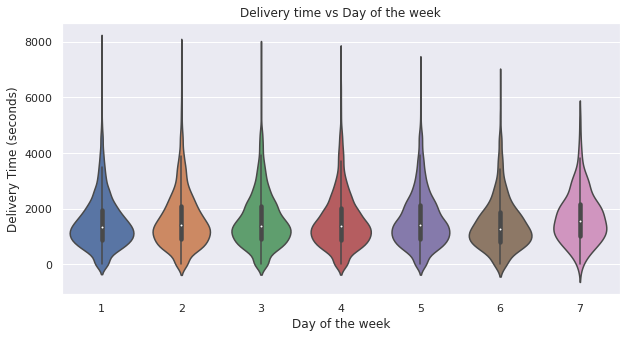

In [26]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.violinplot(x = Train.iloc[:,12], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery time vs Day of the week')
_ = plt.xlabel('Day of the week')
_ = plt.ylabel('Delivery Time (seconds)')


**Observations:**
 

*   Deliveries are generally faster over weekends, with the fastest delivery times on Sundays. This could possibly be due to drivers experiencing less traffic over weekends 


## Checking for Multicolinearity
Visulising the correlation between variables using a heatmap


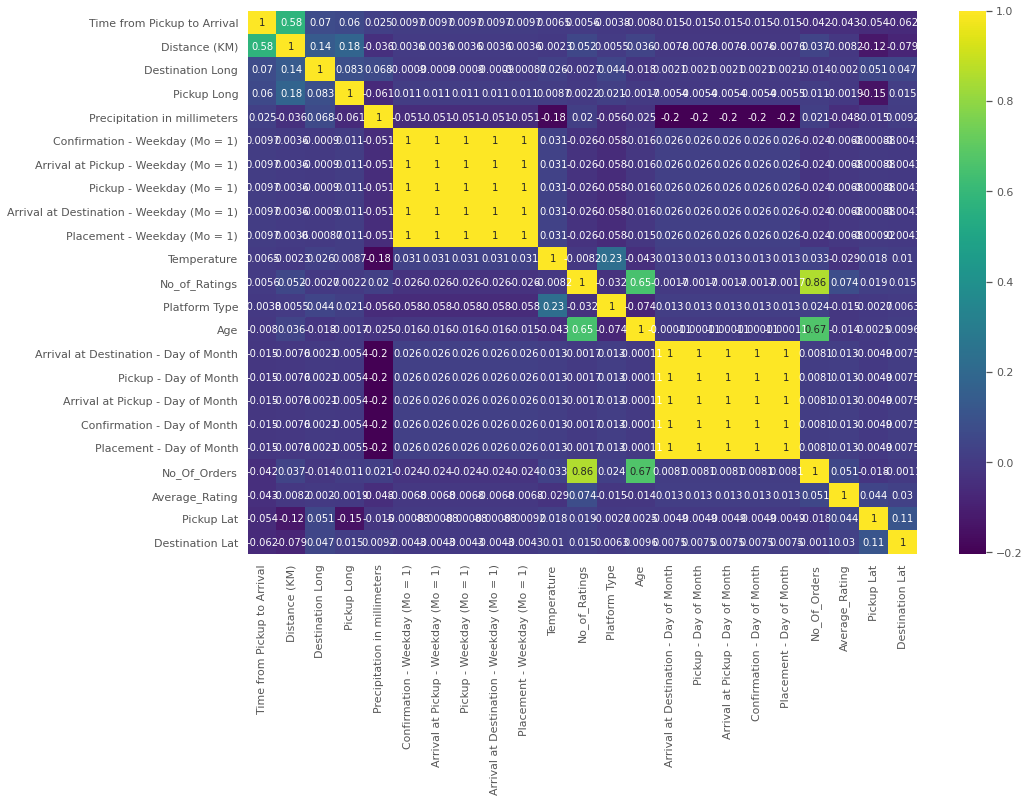

In [27]:
Corr_Matrix = Train.corr()

style.use('ggplot')
k = 33  #number of variables for heatmap
cols = Corr_Matrix.nlargest(k, 'Time from Pickup to Arrival')['Time from Pickup to Arrival'].index
cm = Train[cols].corr()
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, cmap = 'viridis')


**Observations:**

*   The columns relating to the weekday and day of month for the placement, confirmation, arrival at pickup, pickup and arrival at destination are repettitive. Orders are handled in one day, therefore one column for the day of the month and another for the day of week is sufficient.

*   The number of ratings and age columns are highly correlated. From the distribution plots generated earlier it was noted that a large portion of the riders had no or very few ratings. Keeping this in mind, the number of ratings column should be dropped for the following reasons: It adds less value/useful information compared to the age of the riders and introduces multicolinearity into the dataset

* Precipitation is slightly correlated to temperature and day of the month




# Dealing with missing values

*  The NULL values in the temperture column are replaced with the mean.
*  The NULL values in the precipitation column are interperated as days where no rain was recorded and are therefore replaced with 0.

In [0]:
from sklearn.impute import SimpleImputer

# Replacing Null values in the temperature column with the average value 
imputer_temp = SimpleImputer(missing_values = np.NaN, strategy = 'mean')
imputer_temp_1 = SimpleImputer(missing_values = np.NaN, strategy = 'mean')

# Train 
imputer_temp.fit(Train.iloc[:,20:22])
Train.iloc[:,20:22] = imputer_temp.transform(Train.iloc[:,20:22])

# Test
imputer_temp_1.fit(Train.iloc[:,17:19])
Test.iloc[:,17:19] = imputer_temp_1.transform(Test.iloc[:,17:19])

# Replacing the Null values in the precipitation column with 0
imputer_prec = SimpleImputer(missing_values = np.NaN, strategy = 'constant', fill_value = 0)
imputer_prec_1 = SimpleImputer(missing_values = np.NaN, strategy = 'constant', fill_value = 0)

# Train
imputer_prec.fit(Train.iloc[:,22:])
Train.iloc[:,22:] = imputer_prec.transform(Train.iloc[:,22:])

# Test
imputer_prec_1.fit(Test.iloc[:,19:22])
Test.iloc[:,19:22] = imputer_prec_1.transform(Test.iloc[:,19:22])        

# Dropping rows with invalid entries
As mentioned eralier, a few data points corresponding to a delivery time of 1 second were identified. This raised some concerns around the quality of the training dataset. Following this, entries with unrealistic delivery times will be dropped from the dataset before using it to train any models.

The minimum distance covered for deliveries was identified as 1km. Using the speed limit of 60km/h as a guide, the minimum delivery time was calculated as 60 seconds. This is then used as a threshold to determine which entries should be dropped and which should be kept.

Following this approach 740 entries could be excluded.

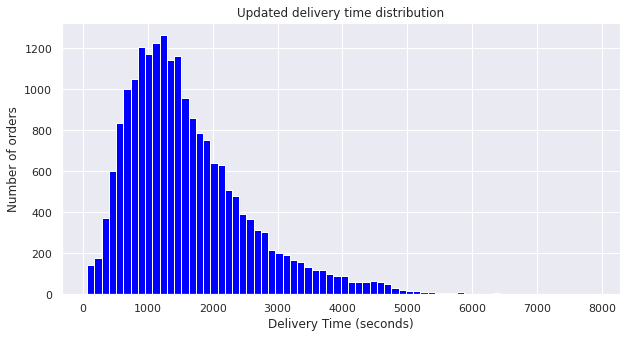

In [33]:
Train.drop(Train.loc[Train['Time from Pickup to Arrival'] < 60].index, inplace=True)

# new distribution of delivery times in seconds
sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.hist(Train['Time from Pickup to Arrival'], bins = 70, color = 'blue')
_ = plt.title('Updated delivery time distribution')
_ = plt.xlabel('Delivery Time (seconds)')
_ = plt.ylabel('Number of orders')

# Dropping columns with repeated or unnecessary information

*  As discussed previously, the day of the month and day of the week are the same for the order placement, confirmation, ect. One column for the day of the month and another for the day of the week is sufficient.

* The ID columns can be dropped as they don't add information that will be usefull in training the ML models

* The Vehicle type column only contains one value - 'Bike' and can therefore be dropped

* The number of ratings column has a strong correlation with the number of orders. Of the two columns, the number of ratings is the least useful and can be dropped (it has the lowest variance as the majority of riders have no or very few ratings)

* The average ratings column has very low variance with most drivers scoring around 13 - 14. The low variance means this feature will not make a significant contibution to the models' predictive power and should be dropped

* The number of orders and age are highly correlated. The longer a rider as been working, the more orders they would have handled. Only one of these columns should be kept going forward. The number of orders handled is a better indication of how experienced a driver is. Following this reasoning, the age column should be dropped

In [30]:
# List of all the column names that should be dropped from the train and test data
to_drop = ['Order No', 'User Id', 'Rider Id', 'Vehicle Type', 'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)', 'Confirmation - Time', 
           'Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time', 'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)',
             'No_of_Ratings', 'No_Of_Orders', 'Average_Rating']

# drop from train and test
Test.drop(to_drop, axis = 1, inplace = True)
Train.drop(to_drop, axis = 1, inplace = True)

Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20461 entries, 0 to 21200
Data columns (total 18 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Platform Type                              20461 non-null  int64  
 1   Personal or Business                       20461 non-null  object 
 2   Placement - Day of Month                   20461 non-null  int64  
 3   Placement - Weekday (Mo = 1)               20461 non-null  int64  
 4   Placement - Time                           20461 non-null  object 
 5   Pickup - Time                              20461 non-null  object 
 6   Arrival at Destination - Day of Month      20461 non-null  int64  
 7   Arrival at Destination - Weekday (Mo = 1)  20461 non-null  int64  
 8   Arrival at Destination - Time              20461 non-null  object 
 9   Distance (KM)                              20461 non-null  float64
 10  Temperature           

# Feature Engineering
The following new features will be created using the existing information to better catagorise data points which will help improve the model predictions:


*   Temperature = pleasant/unpleasant 
*   Age of rider = experience (inexperienced, average, experienced)
*   day of the week = weekend/weekday
*   Time of day = AM/PM

###Creating temperature categories 
The temperature during delievery can be interperated as either pleasant or unpleasant, where extreme conditions are unpleasant. Temperatures between 19 and 28 degrees will be conscidered pleasant.





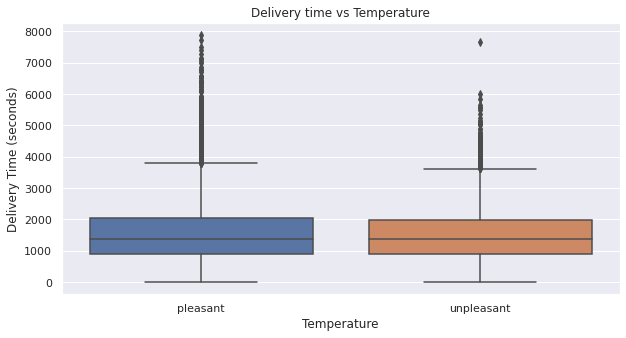

In [0]:
def conv_temp(df):
    type_of_temp = []

    for t in df['Temperature']:
        if (t < 19.0 or t > 28.0):  
           type_of_temp.append('unpleasant')
        else: type_of_temp.append('pleasant')
    df['Temperature'] = type_of_temp
    return

conv_temp(Train) 
conv_temp(Test)

sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Temperature'], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery time vs Temperature')
_ = plt.xlabel('Temperature')
_ = plt.ylabel('Delivery Time (seconds)')


Observations:

*   More outliers and slightly longer delivery times when the weather is pleasant




### Converting the age of the driver into an experience feature

The experience level of the drivers will be divided into 3 categories: inexperinced, average and experienced based on the quartiles 


In [0]:
Riders.describe()

,No_Of_Orders,Age,Average_Rating,No_of_Ratings
count,960.000000,960.000000,960.000000,960.000000
mean,1864.851042,1200.234375,13.412604,427.983333
std,1880.337785,810.930171,2.675794,486.957931
min,2.000000,96.000000,0.000000,0.000000
25%,261.750000,478.250000,13.500000,30.000000
50%,1475.500000,1021.000000,14.000000,223.000000
75%,2847.250000,1891.500000,14.300000,678.750000
max,9756.000000,3764.000000,15.200000,2298.000000


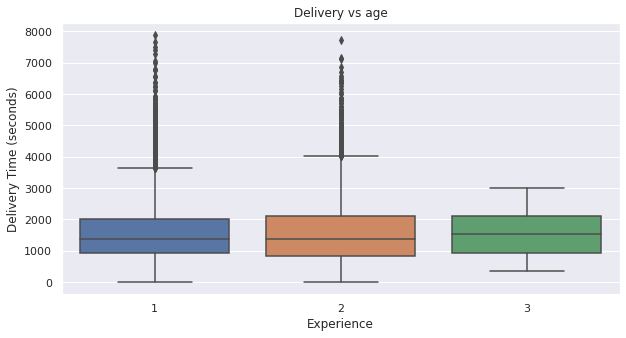

In [0]:
def experience(df):
  exp = []  
  for age in df['Age']:
    if (age < 1021):
      exp.append(1)
    elif (age > 1021 & age < 1891.5):
      exp.append(2)
    else: exp.append(3)
  df['Age'] = exp
  return

experience(Train)
experience(Test)

sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Age'], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery vs age')
_ = plt.xlabel('Experience')
_ = plt.ylabel('Delivery Time (seconds)')


Observations:


*   Less experienced drivers have longer delivery times with more outliers
*   More experienced drivers have less varience and outliers in terms of their delivery times 




### Converting the day of the week into a weekday or weekend feature

days 1 - 5 are weekdays, while 6 and 7 are weekeds



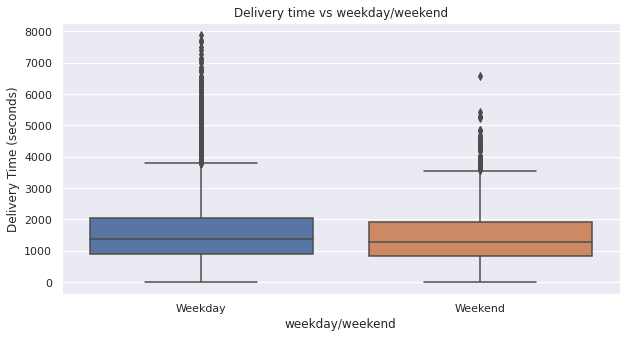

In [0]:
Train['Pickup - Weekday (Mo = 1)'] = np.where(Train['Pickup - Weekday (Mo = 1)']<6, 'Weekday', 'Weekend')
Test['Pickup - Weekday (Mo = 1)'] = np.where(Test['Pickup - Weekday (Mo = 1)']<6, 'Weekday', 'Weekend')

sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Pickup - Weekday (Mo = 1)'], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery time vs weekday/weekend')
_ = plt.xlabel('weekday/weekend')
_ = plt.ylabel('Delivery Time (seconds)')


Observations:

*   Deliveries are generally faster over weekends. This could possibly be due to drivers experiencing less traffic over weekends 
*   More outliers during the week



### Coverting the time of pickup feature into a time of day feature

creating a function that will categorise the time of day into morning, afternoon and evening for both the train and test data


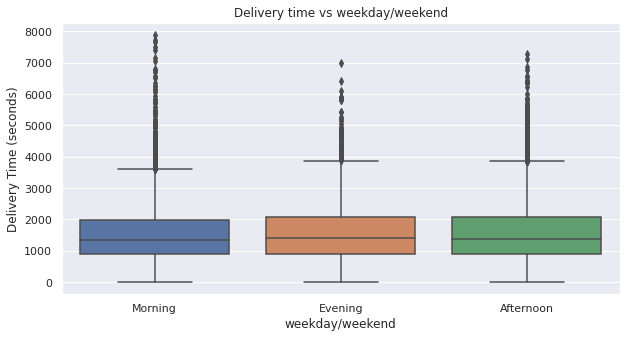

In [0]:
Train['Pickup - Time'] = pd.to_datetime(Train['Pickup - Time'])
Test['Pickup - Time'] = pd.to_datetime(Test['Pickup - Time'])

# Extracting the hour from the time for both the traing and testing datasets
Train['Pickup - Time'] = Train['Pickup - Time'].dt.hour 
Test['Pickup - Time'] = Test['Pickup - Time'].dt.hour

def day_time(df):
        Time_of_day = [] 
        for hour in df['Pickup - Time']:
            if (hour<12):
                Time_of_day.append('Morning')
            elif (hour>12 & hour<17):
                Time_of_day.append('Afternoon')
            else:
                Time_of_day.append('Evening')
        df['Pickup - Time'] = Time_of_day 
        return 

day_time(Train)
day_time(Test)

sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['Pickup - Time'], y = Train.iloc[:,28], data = Train )
_ = plt.title('Delivery time vs weekday/weekend')
_ = plt.xlabel('weekday/weekend')
_ = plt.ylabel('Delivery Time (seconds)')

Observations:


*  More outliers are observed in the mornings, leaning towards longer delivery times in the morining compared to afternoon and evenings


# Encode Categorical data

* Temperature
* Personal or Business
* Weekday
* Time of day








In [0]:
# Create a dictionaries
dic = {'Personal': 0,'Business': 1} 

# use the dictionaries to modify the columns with 'lightswitch' features 
Train_lin['Personal or Business'].replace(dic, inplace=True) 
Test_lin['Personal or Business'].replace(dic, inplace=True)  

df_dummies_train = pd.get_dummies(Train_lin, drop_first=True)
df_dummies_test = pd.get_dummies(Test_lin, drop_first=True)

df_dummies_train.head()



,Platform Type,Personal or Business,Distance (KM),Precipitation in millimeters,Time from Pickup to Arrival,Age,Average_Rating,Pickup - Weekday (Mo = 1)_Weekend,Pickup - Time_Evening,Pickup - Time_Morning,Temperature_unpleasant
0,3,1,4.0,0.0,745,2,13.8,0,0,1,0
1,3,0,16.0,0.0,1993,1,13.6,0,0,1,0
2,3,1,3.0,0.0,455,1,12.5,0,1,0,0
3,3,1,9.0,0.0,1341,1,14.5,0,0,1,0
4,1,0,9.0,0.0,1214,1,14.1,0,0,1,1


# Split Train data into predictors and respons variables

afterwards, the predictors will be standardized

In [0]:
X = df_dummies_train.copy()
X.drop('Time from Pickup to Arrival', axis = 1, inplace = True)

X.head()

,Platform Type,Personal or Business,Distance (KM),Precipitation in millimeters,Age,Average_Rating,Pickup - Weekday (Mo = 1)_Weekend,Pickup - Time_Evening,Pickup - Time_Morning,Temperature_unpleasant
0,3,1,4.0,0.0,2,13.8,0,0,1,0
1,3,0,16.0,0.0,1,13.6,0,0,1,0
2,3,1,3.0,0.0,1,12.5,0,1,0,0
3,3,1,9.0,0.0,1,14.5,0,0,1,0
4,1,0,9.0,0.0,1,14.1,0,0,1,1


In [0]:
y = df_dummies_train['Time from Pickup to Arrival']
#print(y)

In [0]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)
X_std = pd.DataFrame(X_scaled, columns=X.columns)

#X_std.head()

#print(y)

# Building the different models

* Multiple linear regression
* Decision Tree Regression
* Random Forest Regression





In [0]:

# splitting the data in a test and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Building a linear regression model 
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

# Building a decision tree regression model 
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

# Building a random forest regression model 
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 500)
forest.fit(X_test, y_test)

from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.01)
ridge.fit(X_train,y_train) 


Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

#Calculating RMSE

In [0]:
from sklearn.metrics import mean_squared_error

# Multiple linear regression
y_pred_test = lm.predict(X_test)
y_pred_train = lm.predict(X_train)
rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),2)
rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),2)

# Decision Tree regression
y_pred_test_tree = tree.predict(X_test)
y_pred_train_tree = tree.predict(X_train)
rmse_test_tree = round(np.sqrt(mean_squared_error(y_test, y_pred_test_tree)),2)
rmse_train_tree = round(np.sqrt(mean_squared_error(y_train, y_pred_train_tree)),2)

# Random forrest regression 
y_pred_test_forest = forest.predict(X_test)
y_pred_train_forest = forest.predict(X_train)
rmse_test_forest = round(np.sqrt(mean_squared_error(y_test, y_pred_test_forest)),2)
rmse_train_forest = round(np.sqrt(mean_squared_error(y_train, y_pred_train_forest)),2)

# Ridge regression
y_pred_ridge_train= ridge.predict(X_train)
y_pred_ridge_test= ridge.predict(X_test)
rmse_test_ridge = round(np.sqrt(mean_squared_error(y_test, y_pred_ridge_test)),2)
rmse_train_ridge = round(np.sqrt(mean_squared_error(y_train, y_pred_ridge_train)),2)

data = {'Regression model':  ['Mulitiple linear', 'Decision Tree', 'Random Forest', 'Ridge'],
        'RMSE Training': [rmse_train, rmse_train_tree, rmse_train_forest, rmse_train_ridge],
        'RMSE Testing' : [rmse_test, rmse_test_tree, rmse_test_forest, rmse_test_ridge]
        }

df = pd.DataFrame (data, columns = ['Regression model', 'RMSE Training', 'RMSE Testing'])
df.head()


,Regression model,RMSE Training,RMSE Testing
0,Mulitiple linear,797.43,810.63
1,Decision Tree,600.04,960.00
2,Random Forest,885.01,530.13
3,Ridge,797.43,810.63


In [0]:

# Multiple linear regression
y_pred_lin = lm.predict(df_dummies_test)

# Decision Tree regression
y_pred_tree = tree.predict(df_dummies_test)

# Random forrest regression 
y_pred_forest = forest.predict(df_dummies_test)

y_pred_ridge = ridge.predict(df_dummies_test)

# Submission
sb_dataframe = Test.iloc[:,:3]
sb_dataframe['Time from pick up to arrival 1'] = y_pred_forest
sb_dataframe.drop('User Id', inplace = True, axis = 1)
sb_dataframe.drop('Vehicle Type', inplace = True, axis = 1)

print(sb_dataframe)
sb_dataframe.to_csv('submission_random_forest.csv', index = False)



            Order No  Time from pick up to arrival 1
0     Order_No_19248                      619.299681
1     Order_No_12736                     1122.875956
2       Order_No_768                      904.063238
3     Order_No_15332                     1257.085232
4     Order_No_21373                     1058.001704
...              ...                             ...
7063   Order_No_3612                      904.063238
7064   Order_No_7657                     3119.387262
7065   Order_No_1969                     2172.621767
7066  Order_No_10591                     2289.930852
7067   Order_No_1603                     1284.994065

[7068 rows x 2 columns]


In [0]:
print(Sub)

            Order_No  Time from Pickup to Arrival
0     Order_No_19248                        567.0
1     Order_No_12736                       4903.0
2       Order_No_768                       5649.0
3     Order_No_15332                          NaN
4     Order_No_21373                          NaN
...              ...                          ...
7063   Order_No_3612                          NaN
7064   Order_No_7657                          NaN
7065   Order_No_1969                          NaN
7066  Order_No_10591                          NaN
7067   Order_No_1603                          NaN

[7068 rows x 2 columns]
